De los datasets de UCI Machine Learning, tomé Activity Recognition from Single Chest-Mounted Accelerometer Data Set <br>

La URL es: https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip

https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer


Source:<br>

Uncalibrated Accelerometer Data are collected from 15 participantes performing 7 activities. The dataset provides challenges for identification and authentication of people using motion patterns.


Data Set Information:<br>

--- The dataset collects data from a wearable accelerometer mounted on the chest <br>
--- Sampling frequency of the accelerometer: 52 Hz <br>
--- Accelerometer Data are Uncalibrated <br>
--- Number of Participants: 15 <br>
--- Number of Activities: 7 <br>
--- Data Format: CSV<br>

Attribute Information:<br>

--- Data are separated by participant <br>
--- Each file contains the following information <br>
---- sequential number, x acceleration, y acceleration, z acceleration, label <br>
--- Labels are codified by numbers <br>
--- 1: Working at Computer <br>
--- 2: Standing Up, Walking and Going updown stairs <br>
--- 3: Standing <br>
--- 4: Walking <br>
--- 5: Going UpDown Stairs <br>
--- 6: Walking and Talking with Someone <br>
--- 7: Talking while Standing <br>

In [1]:
#Importamos las librerías que vamos a usar:
import requests
import io
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import r2_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score, silhouette_score, davies_bouldin_score, calinski_harabaz_score

In [2]:
#Función para extraer el archivo ZIP
def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        df = pd.DataFrame()
        for i in range(1,2): #Es de 1 a 10 pero por lo largo de los archivos solo tomé 2 para pruebas
            temp_df = pd.read_csv(thezip.open('Activity Recognition from Single Chest-Mounted Accelerometer/'+str(i)+'.csv'),header=None)
            df = df.append(temp_df, ignore_index = True)
    
    return df

<br>
Definimos algunas funciones para las validaciones Extrínsecas <br>
<br>

In [3]:
def evaluaciones(DS, DSReal, DSPred):
    #Matriz de confusión
    cm = confusion_matrix(DSReal, DSPred,labels=[1,2,3,4,5,6,7])
    #Precisión y Recall por label
    print("label precision recall")
    for label in range(1,7):
      print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")
    #Precisión y recall total
    print("precision total:", precision_macro_average(cm))
    print("recall total:", recall_macro_average(cm))
    #Accuracy total
    print('Accuracy total: ', accuracy(cm))
    #Número de datos por Label Real
    print('Número de datos por etiqueta en el Dataset Real')
    print(DSReal.value_counts().sort_index())
    #Número de datos por Label Pred
    print('Número de datos por etiqueta en el Dataset Predecido')
    print(DSPred.value_counts().sort_index())    
    #R cuadrado
    print('R Cuadrado es : ',r2_score(DSReal, DSPred))
    #RMSSTD homogeneidad de los clústeres del agrupamiento
    print('RMSSTD es: ',homogeneity_score(DSReal, DSPred))
    #Mutual Info
    print('La información mutua es: ',mutual_info_score(DSReal, DSPred))
    #calinski harabaz
    #print('calinski harabaz: ',calinski_harabaz_score(DS, DSPred))
    

In [4]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

<br>
Se extrae el archivo etiquetado con el que se harán las diferentes pruebas con los modelos <br>
<br>

In [5]:
#Extracción del archivo
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip'

Dataset=download_extract_zip(url)

Dataset.head()

,0,1,2,3,4
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [6]:
len(Dataset)

162501

In [7]:
Dataset=Dataset.dropna() #Borrar NaN
Dataset=Dataset[(Dataset[[4]] != 0).all(axis=1)] #Borrar labels con 0 ya que según la descripción no existen

In [8]:
#Tomando en cuenta que la columna 0 es un número secuencial y la columna 4 el label, 
#tomaremos de las columnas 1 a 3 para aplicar el Kmeans
X = Dataset.iloc[: , 1:4]


<br>
## **Clusters Basado en Particiones**<br>
## **Aplicando Kmeans**<br>
<br>

In [9]:
#los labels son 7 por esto el Kmeans lo dejaré en 7 sin aplicar el elbow method.

kmeans = KMeans(n_clusters = 7, init='k-means++', max_iter=200, n_init=200, random_state=0)
y_kmeans = kmeans.fit_predict(X)
#Agrego al final del Dataset la columna means para analizar los resultados
Dataset['kmeans']=y_kmeans+1

<br>
Se evalúa el algoritmo <br>

In [10]:
#Aplicar Evluación por indicadores:
evaluaciones(X, Dataset[4], Dataset['kmeans'])

label precision recall
    1     0.002  0.083
    2     0.024  0.007
    3     0.027  0.070
    4     0.040  0.186
    5     0.085  0.132
    6     0.583  0.143
precision total: 0.11072672251886735
recall total: 0.08953422565009163
Accuracy total:  0.09336615384615385
Número de datos por etiqueta en el Dataset Real
1    33677
2      928
3    11179
4    26860
5     3191
6     2917
7    83748
Name: 4, dtype: int64
Número de datos por etiqueta en el Dataset Predecido
1    10651
2    38140
3     3202
4    70619
5    14766
6     4532
7    20590
Name: kmeans, dtype: int64
R Cuadrado es :  -0.009240936107933528
RMSSTD es:  0.47249282274595733
La información mutua es:  0.6276153075113974


Con esta aplicación de modelo jugamos un poco el el parámetro n_init y las iteraciones máximas. <br>
Un n_init muy grande iba desmejorando el algoritmo, al igual que uno muy pequeño, ese punto de (200) dió el mejor resultado.<br>
Sin embargo fueron resultados muy bajos, tomando en cuenta que la precisión total fue de 0.11 y la exhaustividad de 0.089<br>

<br>
## **Clusters por Agrupamiento Jerárquico**<br>
## **Aglomerativo**<br>
<br>

Usare el dataset llamado X_Ds para hacer más rapido los clusters

In [11]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
#Creo un dataset mas pequeño para el cluster jerárquico ya que el dataset completo era demasiado costoso aplicar
from sklearn.model_selection import train_test_split
#Cree con el mismo que se hace el split para asegurar tomar una muestra de todos los labels
X_Ds2, X_Ds = train_test_split(Dataset, test_size = 0.2, random_state = 0)

X_Jer=X_Ds.iloc[:,1:4]

In [13]:
len(X_Ds)

32500

In [14]:
modeloAglomerativo = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage="ward")
modeloAglomerativo = modeloAglomerativo.fit(X_Jer)

In [15]:
YAglomerativo = modeloAglomerativo.fit_predict(X_Jer)

In [16]:
#Agrego al final del Dataset la columna means para analizar los resultados
X_Ds['jerarquico']=YAglomerativo+1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


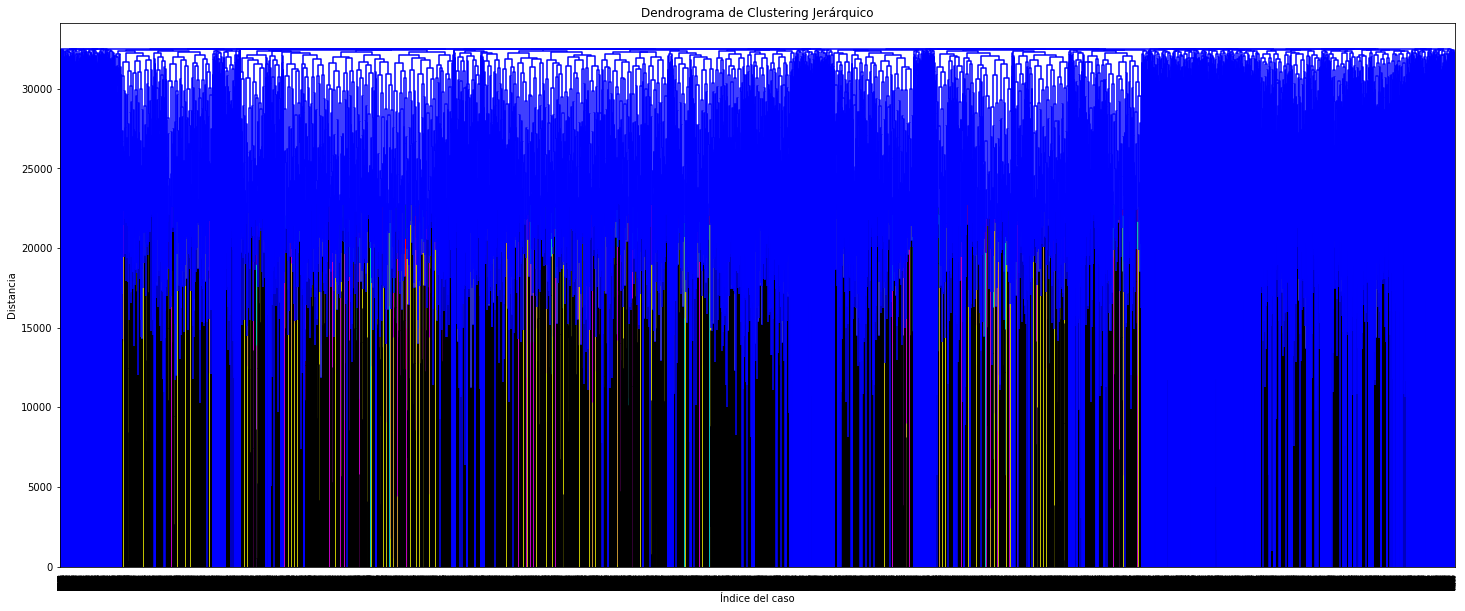

In [17]:
# Creamos la matriz de enlaces que necesita el método dendrogram de scipy
uniones = modeloAglomerativo.children_
# Las distancias y los tamaños, en esta ocasión, los asignamos de manera 
# inocua para no alterar el resultado (no disponemos de la información completa)
distancias = np.arange(uniones.shape[0])
tamanyos = np.arange(2, uniones.shape[0]+2)
mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

plt.figure(figsize=(25, 10))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(mEnlaces)
plt.show()

<br>
Evaluación del clustering jerárquico <br>
<br>

In [18]:
#Aplicar Evluación por indicadores:
evaluaciones(X_Jer, X_Ds[4], X_Ds['jerarquico'])

label precision recall
    1     0.006  0.278
    2     0.003  0.011
    3     0.559  0.107
    4     0.048  0.199
    5     0.004  0.057
    6     0.772  0.161
precision total: 0.19931459116573902
recall total: 0.11625661677179497
Accuracy total:  0.10836923076923077
Número de datos por etiqueta en el Dataset Real
1     6670
2      205
3     2277
4     5296
5      629
6      575
7    16848
Name: 4, dtype: int64
Número de datos por etiqueta en el Dataset Predecido
1    1280
2    8851
3    7364
4    1018
5    2587
6    7890
7    3510
Name: jerarquico, dtype: int64
R Cuadrado es :  -0.2270019408651316
RMSSTD es:  0.4863231624983627
La información mutua es:  0.6454388382633762


Con este modelo comenzamos a tener problemas por el tamaño del dataset, debido a la cantidad de registros y teniendo en cuenta que el dataset tiene 3 variables, por esta razón lo acortamos, usando el split (train_test_split) para asegurar que iba a tomar valores aleatorios en el dataset. <br>
El parámetro afinity también se dejó en euclidean por los mismos problemas de memoria debido al tamaño del dataset.<br>
Los resultados totales son un poco mejor que el modelo anterior, la precisión total fue de 0.19 y la exhaustividad de 0.11<br>

<br>
## **Agrupamiento Espectral**<br>
## **Cluster Espectral**<br>
<br>

In [37]:
from sklearn.cluster import SpectralClustering
K = 7
knn = 5
clustering = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                #affinity = 'rbf',
                                random_state = 0).fit(X_Jer)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [20]:
#Agrego al final del Dataset la columna means para analizar los resultados
X_Ds['espectral']=clustering.labels_+1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
X_Ds.head()

,0,1,2,3,4,kmeans,jerarquico,espectral
20097,20097.0,1971,2378,2121,1,2,3,2
136660,136660.0,1897,2383,1973,7,4,6,7
102885,102880.0,1907,2386,2009,7,4,6,4
126058,126060.0,1875,2380,2002,7,4,2,1
47090,47090.0,1887,2276,2028,4,1,5,3


<br>
Aplicar evaluación del modelo <br>
<br>

In [22]:
#Aplicar Evluación por indicadores:
evaluaciones(X, X_Ds[4], X_Ds['espectral'])

label precision recall
    1     0.001  0.044
    2     0.021  0.071
    3     0.056  0.076
    4     0.000  0.000
    5     0.000  0.000
    6     0.964  0.290
precision total: 0.14892742607912948
recall total: 0.06864611130029771
Accuracy total:  0.1678769230769231
Número de datos por etiqueta en el Dataset Real
1     6670
2      205
3     2277
4     5296
5      629
6      575
7    16848
Name: 4, dtype: int64
Número de datos por etiqueta en el Dataset Predecido
1    5844
2    6912
3    7549
4    7115
5       5
6       5
7    5070
Name: espectral, dtype: int64
R Cuadrado es :  -0.4752111962695509
RMSSTD es:  0.4850670192674655
La información mutua es:  0.6437717088931081


Con este modelo tomamos el mismo dataset acortado y se tomará en los posteriores modelos, acá los parámetros de affinity 'nearest_neighbors' la verdad fueron los únicos que corrieron, los demás por el tamaño del dataset daban memory error. <br>
Los resultados totales fueron semejantes a kmean con una precisión total fue de 0.14 y la exhaustividad de 0.06<br>

<br>
## **Agrupamiento Densidad**<br>
## **DBSCAN**<br>
<br>

In [23]:
from sklearn.cluster import DBSCAN
eps = .1
M = 38

clustering_db = DBSCAN(eps=eps, min_samples=M).fit(X_Ds)


In [24]:
clustering_db.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [25]:
#Agrego al final del Dataset la columna means para analizar los resultados
X_Ds['dbscan']=clustering_db.labels_+1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Aplicar Evaluación <br>

In [26]:
#Aplicar Evluación por indicadores:
evaluaciones(X, X_Ds[4], X_Ds['dbscan'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in longlong_scalars


label precision recall
    1       nan    nan
    2       nan    nan
    3       nan    nan
    4       nan    nan
    5       nan    nan
    6       nan    nan
precision total: nan
recall total: nan
Accuracy total:  nan
Número de datos por etiqueta en el Dataset Real
1     6670
2      205
3     2277
4     5296
5      629
6      575
7    16848
Name: 4, dtype: int64
Número de datos por etiqueta en el Dataset Predecido
0    32500
Name: dbscan, dtype: int64
R Cuadrado es :  -4.111634904723658
RMSSTD es:  -3.9735044080519694e-16
La información mutua es:  -5.273559366969494e-16


In [27]:
from sklearn.cluster import MeanShift
h=5
clustering = MeanShift(bandwidth = h).fit(X_Ds)

In [28]:
#Agrego al final del Dataset la columna means para analizar los resultados
X_Ds['meanshift']=clustering.labels_+1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Aplicar Evaluación del modelo <br>

In [29]:
#Aplicar Evluación por indicadores:
evaluaciones(X, X_Ds[4], X_Ds['meanshift'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


label precision recall
    1     0.000    nan
    2     0.000    nan
    3     0.000    nan
    4     0.000    nan
    5     0.000    nan
    6     1.000  0.132
precision total: 0.14285714285714285
recall total: nan
Accuracy total:  0.13157894736842105
Número de datos por etiqueta en el Dataset Real
1     6670
2      205
3     2277
4     5296
5      629
6      575
7    16848
Name: 4, dtype: int64
Número de datos por etiqueta en el Dataset Predecido
1        6
2        6
3        6
4        5
5        5
6        5
7        5
8        5
9        5
10       6
11       5
12       5
13       5
14       5
15       6
16       5
17       5
18       5
19       5
20       5
21       5
22       5
23       5
24       4
25       6
26       5
27       6
28       5
29       5
30       4
        ..
28382    1
28383    1
28384    1
28385    1
28386    1
28387    1
28388    1
28389    1
28390    1
28391    1
28392    1
28393    1
28394    1
28395    1
28396    1
28397    1
28398    1
28399    1
28400   

In [30]:
X_Ds.head()

,0,1,2,3,4,kmeans,jerarquico,espectral,dbscan,meanshift
20097,20097.0,1971,2378,2121,1,2,3,2,0,25362
136660,136660.0,1897,2383,1973,7,4,6,7,0,6779
102885,102880.0,1907,2386,2009,7,4,6,4,0,10929
126058,126060.0,1875,2380,2002,7,4,2,1,0,398
47090,47090.0,1887,2276,2028,4,1,5,3,0,2415


Para este Dataset ninguno de los algoritmos de agrupamiento por densidad sirvió, primero al no poder parametrizar el número de cluster y sabiendo que teníamos 7 cluster las evaluaciones iban a ser bastante difíciles.
Creo que no vale la pena comentar las evaluaciones ya que son resultados que no deberían tomarse en cuenta.

<br>
## **Agrupamiento Probabilistico**<br>
## **Mixturas Gausianas**<br>
<br>

In [48]:
from sklearn.mixture import GaussianMixture
# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 7, max_iter = 200, covariance_type='spherical')
# Se aprende el modelo
modelo = modelo.fit(X_Ds)
# Se predicen las asignaciones a clústeres
Dyp_sk = modelo.predict(X_Ds)


In [49]:
#Agrego al final del Dataset la columna means para analizar los resultados
X_Ds['gaussmix']=Dyp_sk+1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Aplicar evaluación del modelo 

In [50]:
#Aplicar Evluación por indicadores:
evaluaciones(X, X_Ds[4], X_Ds['gaussmix'])

label precision recall
    1     0.000  0.000
    2     0.000  0.000
    3     0.708  0.660
    4     0.116  1.000
    5     0.000  0.000
    6     0.000  0.000
precision total: 0.11767053760131196
recall total: 0.2371331463098835
Accuracy total:  0.1268923076923077
Número de datos por etiqueta en el Dataset Real
1     6670
2      205
3     2277
4     5296
5      629
6      575
7    16848
Name: 4, dtype: int64
Número de datos por etiqueta en el Dataset Predecido
1    5086
2    4457
3    5408
4    4937
5    5433
6    5400
7    1779
Name: gaussmix, dtype: int64
R Cuadrado es :  -0.8804411644729673
RMSSTD es:  0.6889086473332195
La información mutua es:  0.9143064350874799


Con este modelo, se tomó el ejemplo tal cual como en la VC06, con la única modificación que fue la de asignar la covarianza esférica, dado el tipo de dataset que es de posiciones creo que cada valor debería tener su propia covarianza ya que no se explican unos a otros. <br>
Los resultados totales fueron bastante bajos con una precisión total de 0.11 y la exhaustividad de 0.23<br>